# This notebook demostrates the augmentation of stellar grid models with Gaussian Process Regression (GPR) models.

# workflow: 

S1: Grid computation/selection: Given a star or a star sample with known observations, we could derive the ranges of inputs parameters. Assuming we are working on the Lund's star sample. We use the scalling relation to derive the mass range of the sample, which is from 0.9 - 1.1 solar mass. We could also know their evolving stages (main-sequence dwarf or early subgiants) by inspecting their locations on the HR diagram. Their metallicities are in a range of [Fe/H] = -0.3 -- 0.3 dex which are from the spectroscopy. Their helium fraction and mixing-length parameter are not unknow. We then use a typical ranges for these two parameters. 

S2: Select training data: Training data should cover the whole parameter sapce and we also need to highly-weighted the areas presenting sharp changes (if there are any).

S3: kernel selection and training data validation: we need a kernel which has proper flexibility to fit the feature of evolutionary tracks. A proper kernel should be able to well reproduece all training data. There could be multiple kernels. 

S4: test data validation: All good kernels will be validated with test data, which contents model data on the grid of training data (but not used for training) as well as model data which are off-grid. If the validation results are not good, go back to S2. There could be a couple iterations from S2 to S4.

S5: When the best model is found, use the validation results to estimate systematical uncertainty (could be another GP model.)



In [1]:
import GPy
import pickle
import numpy as np
import matplotlib #
from numpy import *
from matplotlib import *
import pandas as pd
import warnings
import glob
import random
import time
import re
import os, sys
import csv
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import corner



# The lines below are specific to the notebook format
textsize = 25

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

In [2]:
# The global_kernel class is to find GP kernels which are suitable for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class global_md_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None,valipath = None, savepath = None):
        self._datapath = datapath
        self._valipath = valipath
        self._savepath = savepath
        
        if not os.path.exists(datapath):
            raise Warning(f'datapath:' + datapath + ' does not exist')

        if not os.path.exists(valipath):
            raise Warning(f'valipath:' + valipath + ' does not exist')
        
        if not os.path.exists(savepath): os.makedirs(savepath)
        
        print('Data path is set as' + self._datapath)
        print('Validation path is set as' + self._valipath)
        print('Save path is set as' + self._savepath)
        return self
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_grid(self, path = None,
                           condition = None, number = None,
                           columns = None,
                           ranges = None,
                           normalization = None):
        if path == None:
            raise Warning(f'$path$ must be given')

        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, all file will be used', UserWarning)
            number = 9999999999
            
        if (columns == None) or (ranges == None): 
            raise Warning(f'$columns$ and $ranges$ must be given')
        
        #if (validation_frac == None):
        #    warnings.warn(f'$validation_frac$ is missing, 0.2 will be used', UserWarning)
        #    validation_frac = 0.2
    
        all_files = glob.glob(path + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        print(str(n) + ' tracks are found')
        
        #print('the columns names are' + str(columns))
        
        df1 = []
        
        for filename in files:
            df0 = self.get_data_of_a_track(filename = filename, 
                                           columns = columns,
                                           ranges = ranges,
                                           normalization =normalization)
            df1.append(df0)
        
        df = []    
        df = pd.concat(df1, ignore_index=True)
        
        #random_state = 1

        #if (len(df['type'])*(1 - validation_frac) >= 10000):
        #    train = df.sample( n = 10000, random_state=random_state) #random state is a seed value
        #else:
        #    train = df.sample(frac = (1 - validation_frac), random_state=random_state) #random state is a seed value
        
        #df['type'].iloc[train.index] = 'data'
        
        return df
    
    
    
    def get_data_of_a_track(self, filename = None, columns = None, ranges = None, normalization = None):
        '''
        '''        
        one_track = []
        one_track = pd.read_csv(filename)
        
        #m = re.search('yinit(.+?)MLT', filename)
        #if m:
        #    found = m.group(1)
        
        #one_track['initial_Yinit'] = float(found)                
        #get rid of the pre-MS
        #one_track = one_track.loc[one_track['center_h1'] <= 0.997*np.max(one_track['center_h1']) ]
        one_track = one_track[columns]
        #one_track['type'] = 'data'
        one_track['hrgradient'] = ((np.gradient(one_track['effective_T']/5777.0))**2.0 
                                 + (np.gradient(one_track['log_g']/4.44))**2.0
                                  )**0.5
        
        one_track['fagegradient'] = np.gradient(one_track['frac_age'])
      
        for i in range(len(columns)):
            #print(columns[i], ranges[i])
            temp = None
            temp = one_track[(one_track[columns[i]] >= min(ranges[i])) & (one_track[columns[i]] <= max(ranges[i]))]
            if (temp.shape[0] >= 10):
                one_track = one_track.loc[temp.index.min(): temp.index.max()]
                one_track['frac_age'] = one_track['star_age']/np.max(one_track['star_age'])
            else:
                one_track = None
                break
            if (normalization != None):
                if (normalization[i] > -999):
                    one_track[columns[i]] = one_track[columns[i]]/normalization[i]
        return one_track
    
    ##################### Plot section########################################################################################
    
    def preview_2d_data(self, condition = None, number = None,
                        x1 = None, x2 = None ,y = None, 
                        x1log = None, x2log = None, ylog = None, 
                        x1normalization = None, x2normalization = None, ynormalization = None,
                        savefig = None):
        
    
        
        plt.figure(figsize=(12, 10))
        plt.xlabel(x)
        plt.ylabel(x2)
        plt.title('Preview of ' + x + ' vs ' + x2 + ' color: ' + y)
        for filename in files:
            print(filename)
            gpx1, gpx2, gpy, gpx1_v, gpx2_v, gpy_v, x1range, x2range, yrange = \
            self.get_data_of_a_track(filename, x1, x2, y, x1log, x2log, ylog, \
                                     x1normalization, x2normalization, 
                                     ynormalization, fraction = 0.9)
            plt.scatter(gpx1, gpx2, c = gpy)
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x1 + '_vs_' + x2 + '_vs_' + y + 'preview.png')
        return None
    
    def plot_3d_data(self, x = None, y = None, z = None, c = None):
        fig = plt.figure()
        ax = Axes3D(fig)
        cp = ax.scatter(x, y, z, c = c, s=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        colorbar = plt.colorbar(cp)
        colorbar.set_label('c')
        return ax, colorbar 
    
    
   
      #####################Data generating#################
    def generate_2d_surface(self, xv = None, xvstep = None, xf1 = None, xf2 = None, number = None, factor = None):
    
        new_xv = []
        new_xf1 = []
        new_xf2 = []
    
        if factor == None: factor = 10
        
        number = min([factor*len(xv), number])
    
        for i in range(int(factor)):
            aa = xv + xvstep*(np.random.random(len(xv))-0.5)
            new_xv = np.concatenate((new_xv, aa))
            new_xf1 = np.concatenate((new_xf1, xf1))
            new_xf2 = np.concatenate((new_xf2, xf2))
            if (len(new_xv) >= number): break
    
        idxs = np.random.choice(arange(len(new_xv)), number)                           
    
    ######################GP models##################
    
    def kernel_bank(self, kname,input_dim):
        
        ard = True
        
        if kname == 'RBF': 
            k = GPy.kern.RBF(input_dim=input_dim, variance=1., lengthscale=1., ARD = ard)
        elif kname == 'EXP': 
            k = GPy.kern.Exponential(input_dim=input_dim, variance=1., lengthscale=1., ARD = ard)
        elif kname == 'MLP': 
            k = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
        elif kname == 'MLP+RBF':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
            k2 = GPy.kern.RBF(input_dim=input_dim, variance=1., lengthscale=1., ARD = ard)
            k = k1+k2
        elif kname == 'MLP+MLP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
            k2 = GPy.kern.MLP(input_dim = input_dim, ARD=ard)
            k = k1+k2
        elif kname == 'MLP*MLP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
            k2 = GPy.kern.MLP(input_dim = input_dim, ARD=ard)
            k = k1*k2
        elif kname == 'MLP+EXP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
            k2 = GPy.kern.Exponential(input_dim = input_dim, ARD=ard)
            k = k1+k2
        elif kname == 'MLP+RQ':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
            k2 = GPy.kern.RatQuad(input_dim = input_dim, ARD=ard)
            k = k1+k2
        elif kname == 'RQ':
            k = GPy.kern.RatQuad(input_dim = input_dim, ARD=ard)
        elif kname == 'Mat32':
            k = GPy.kern.Matern32(input_dim = input_dim, ARD=ard)
        else: 
            k = None
        return k

    
    def gp_a_dataframe(self, df = None, xcolumns = None, ycolumns = None, kname = None):
        
        start_time = time.time()
        nx = len(xcolumns)
        ny = len(ycolumns)
        #if (ny != 1):
        #    raise Warning(f'y must be 1 dimession!')

        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        if (ny > 1):
            yy = df[ycolumns].to_numpy()
        else:
            yy = df[ycolumns].to_numpy().reshape(-1,1)

        kernel = self.kernel_bank(kname, nx)
        if (kernel == None):
            raise Warning('kname:'+ kanme + ' is not found')
            
        gpm = GPy.models.GPRegression(xx,yy,kernel)
        gpm.optimize()
        print("--- %s seconds ---" % (time.time() - start_time))
        return gpm
    
    ###################################################
    def load_a_gpm(self, df = None, npy = None, xcolumns = None, ycolumns = None, kname = None):
        
        nx = len(xcolumns)
        ny = len(ycolumns)

        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        if (ny > 1):
            yy = df[ycolumns].to_numpy()
        else:
            yy = df[ycolumns].to_numpy().reshape(-1,1)

        kernel = self.kernel_bank(kname, nx)
        if (kernel == None):
            raise Warning('kname:'+ kanme + ' is not found')
            
        m_load = GPy.models.GPRegression(xx,yy,kernel,initialize=False)
        m_load.update_model(False) # do not call the underlying expensive algebra on load
        m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
        m_load[:] = np.load(npy) # Load the parameters
        m_load.update_model(True) # Call the algebra only once
        print(m_load)
        return m_load

    
    ######################inspecting model######################
    def inspect_gpm_on_1d(self, gpm = None, df = None, xcolumns = None, ycolumns = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        if (ny != 1):
            raise Warning(f'y must be 1 dimession!')
            
        ndf = len(df)
        
        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        gpy = gpm.predict(xx)
        
        for name in xcolumns:
            fig, ax = plt.subplots(1, figsize=(6,5))
            ax.scatter(df[name], df[ycolumns],s = 10, c = 'k')
            ax.scatter(df[name], gpy[0].reshape(ndf,), s = 5, c = 'r')
            ax.set_xlabel(name)
            ax.set_ylabel(ycolumns)
        return
    
        #########################
        #####################
    
    ####
    def inspect_gpm_on_2d(self, gpm = None, df = None, xcolumns = None, ycolumns = None, xplots = None,
                          randomshift = None, shiftfactor = None, title = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        if (ny != 1):
            raise Warning(f'y must be 1 dimession!')
            
        ndf = len(df)
        
        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
            
        if shiftfactor == None: shiftfactor = 0.01
        if randomshift == True: xx = xx + shiftfactor*xx
        
        gpy = gpm.predict(xx)
        
        nc = len(xplots)
        if nc < 2: raise Warning(f'xplots must be >=2 dimession!')
        
        for i in range(nc):
            name1 = xplots[i]
            for i2 in range(nc-i-1):
                name2 = xplots[i+i2+1]
                print(name1, name2)
                fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
                cp = ax1.scatter(df[name1], df[name2], c = (df[ycolumns[0]] - gpy[0].reshape(ndf,))/df[ycolumns[0]],s = 2)
                #ax.scatter(df[name1], df[name2], c = gpy[0].reshape(ndf,), s = 15)
                ax1.set_xlabel(name1)
                ax1.set_ylabel(name2)
                colorbar = plt.colorbar(cp)
                colorbar.set_label(ycolumns[0] + '(Grid - GP)/Grid')
                ax2.hist((df[ycolumns[0]] - gpy[0].reshape(ndf,))/df[ycolumns[0]], bins = 50)
                if title != None: ax1.set_title(title)
        return

    ######################sampling##############################
    def guassian_sample(self, obs, obs_e, howmanysigma, n):
        x = np.linspace(0,1.0,n)
        mu = 0.5
        sigma = 1.0/howmanysigma/2.0
        y = 1.0/(sigma*(2.0*np.pi)**0.5)*np.exp(-0.5*((x - mu)/sigma)**2.0)
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n - 0.5) *(obs_e*howmanysigma*2) + obs
        return data_array
    
    def uniform_sample(self, obs, obs_e, howmanysigma, n):
        x = np.linspace(0,1.0,n)
        mu = 0.5
        sigma = 1.0/howmanysigma/2.0
        data_array = (np.random.choice(n,n)/n - 0.5) *(obs_e*howmanysigma*2) + obs
        return data_array
    
    def linear_sample(self, start, end, slope, n):
        x = np.linspace(0,1.0,n)
        y = slope*x
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n) *(end - start) + start
        return data_array
    
    def age_sample(self, start, end, slope, n):
        x = np.linspace(0,1.0,n)
        y = slope*x**2
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n) *(end - start) + start
        return data_array
    
    def mle(self, model, obs, obs_e):
        lk = 1.0/ (2.0*3.14159*obs_e**2.0)**(0.5) * np.exp( 0.0 - (model - obs)**2.0/2.0/obs_e**2.0 )
        return lk
    
    def sample_results(self, df = None, lkname = None, f = None):
        df[lkname] = df[lkname]/np.sum(df[lkname])
        newdf = df.copy()
        for index, row in df.iterrows():
            copies = int(f*row[lkname])
            for i in range(copies):
                newdf = newdf.append(row,ignore_index=True)
        newdf.drop(index = df.index,inplace=True)
        return newdf
    
    def sample_cmd(self, gpm = None, df = None, prediction = None, 
               xcolumns = None, xshift = None, randomshift = None,
               ccolumns = None, mcolumns = None):
        nx = len(xcolumns)
        
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.scatter(df[ccolumns], df[mcolumns],c = df[prediction], s = 5)
            
        ndf = len(df)
        
        df2 = df.copy()
        
        for name in xcolumns:
            index = xcolumns.index(name)
            if (randomshift == True):
                df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
            else:
                df2[name] = df2[name] + xshift[index]
        
        if (nx>1):
            xx = df2[xcolumns].to_numpy()
        else:
            xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
        gpp = gpm.predict(xx)
        
        ax2.scatter(df2[ccolumns],df2[mcolumns],c = gpp[0].reshape(ndf,), s = 5)
        ax1.set_xlabel(ccolumns)
        ax1.set_ylabel(mcolumns)
        ax1.set_xlim([np.max(df[ccolumns]), np.min(df[ccolumns])])
        ax2.set_xlim([np.max(df[ccolumns]), np.min(df[ccolumns])])
        ax1.set_ylim([np.max(df[mcolumns]), np.min(df[mcolumns])])
        ax2.set_ylim([np.max(df[mcolumns]), np.min(df[mcolumns])])
        ax1.set_title('Model Grid')
        ax2.set_xlabel(ccolumns)
        ax2.set_title('GP predictions')
        return 
    
    def sample_with_df(self, n = None, df = None, gpm = None, 
               xcolumns = None, xshift = None, randomshift = None,
               ycolumns = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        
        df2 = df.copy()
        if (len(df2) < n):
            for i in range(100):
                df2 = pd.concat([df2, df])
                if len(df2)>n: break
        
        df2.index = range(len(df2))
        
        ndf = len(df2)
        
        for name in xcolumns:
            index = xcolumns.index(name)
            if (randomshift == True):
                df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
            else:
                df2[name] = df2[name] + xshift[index]
        
        if (nx>1):
            xx = df2[xcolumns].to_numpy()
        else:
            xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
        gpp = gpm.predict(xx)
        df2[ycolumns] = gpp[0]
        df2['gp_var'] = gpp[1].reshape(ndf,)
        
        #for yname in ycolumns:
        #    index = ycolumns.index(yname)
        #    gpp = gpm[index].predict(xx)
        #    df2[yname] = gpp[0].reshape(ndf,)
        #    df2[yname + '_var'] = gpp[1].reshape(ndf,)
        return df2



In [3]:
xcolumns = ['initial_mass', 'frac_age','initial_zx']
ycolumns = ['effective_T']#,'log_g','delta_nu_fit'] # 'star_age','star_zx', ]
xshifts = [0.0,0.0,0.0]

ntraining = 10000
nvalidating = 20000
nresidual = 50000

In [4]:
datadr = '/Users/litz/Documents/GitHub/data/simple_grid_alex/'
savedr = '/Users/litz/Documents/GitHub/GPGrid/paper_used/3D_fun_to_obs/' + ycolumns[0] + '/'
validr = '/Users/litz/Documents/GitHub/data/validation_data/simple_grid_vali_3d/'
gmk = global_md_kernel()
gmk.set_path(datapath = datadr, savepath = savedr, valipath = validr)

Data path is set as/Users/litz/Documents/GitHub/data/simple_grid_alex/
Validation path is set as/Users/litz/Documents/GitHub/data/validation_data/simple_grid_vali_3d/
Save path is set as/Users/litz/Documents/GitHub/GPGrid/paper_used/3D_fun_to_obs/effective_T/


# section 3.2 3D-inputs GPR models: p = f(mass, frac_age, initial feh)

In [5]:
columns = ['evol_stage',
           'initial_mass',
           'initial_Yinit',
           'initial_feh',
           'initial_MLT',
           'star_age',
           'frac_age',
           'ms_age',
           'effective_T',
           'log_g',
           'radius',
           'star_feh',
           'delta_nu_fit',
           'nu_max']
ranges = [[1,100],
          [0.0,2.0], 
          [0.0,2.0],
          [-0.5,0.5],
          [0.00,99.0],
          [-1.0e99, 1.0e99],
          [0.01,2.00], 
          [-1.0e99,1.0e99],
          [-999999,999999],
          [3.8000,999999.0],#[(obs_logg - 5.0*obs_logg_e), (obs_logg + 5.0*obs_logg_e)],
          [-9999,9999],
          [-99999,999999],
          [-9999.0,999999],
          [-999999,999999]
         ]

normalization = [-9999,-9999, -9999, -9999, -9999,-9999, -9999, -9999,
                 -9999, -9999, -9999,-9999, 
                 -9999,-9999]

#df = gmk.get_data_of_a_grid(path = gmk._datapath,
#                               condition = 'm*Y0.28FeH*MLT2.1ov0.0dif1.csv', number = None,
#                               columns = columns,
#                               ranges = ranges, 
#                               normalization = normalization)
#df['initial_zx'] = 10**df['initial_feh']*0.0181
#df['star_zx'] = 10**df['star_feh']*0.0181
#df['frac_age'] = 10**df['frac_age']

#df.to_csv(savedr + 'df.csv')

df = pd.read_csv(savedr + 'df.csv')

#dfvon = df.sample(n = nvalidating, weights = 'hrgradient', random_state = 78)
#dfvon.to_csv(savedr + 'dfvon.csv')
df

Unnamed: 0  evol_stage  initial_mass  initial_Yinit  initial_feh  \
0                0           1          1.05           0.28         0.00   
1                1           1          1.05           0.28         0.00   
2                2           1          1.05           0.28         0.00   
3                3           1          1.05           0.28         0.00   
4                4           1          1.05           0.28         0.00   
...            ...         ...           ...            ...          ...   
293235      293235           2          0.98           0.28         0.45   
293236      293236           2          0.98           0.28         0.45   
293237      293237           2          0.98           0.28         0.45   
293238      293238           2          0.98           0.28         0.45   
293239      293239           2          0.98           0.28         0.45   

        initial_MLT   star_age   frac_age     ms_age  effective_T     log_g  \
0               2.1   0.089514   1.026542   5.701476  6020.401864  4.487184   
1               2.1   0.102056   1.030317   5.701476  6021.004397  4.486433   
2               2.1   0.117105   1.034864   5.701476  6021.569058  4.485608   
3               2.1   0.135165   1.040348   5.701476  6022.148049  4.484698   
4               2.1   0.156836   1.046967   5.701476  6022.769456  4.483688   
...             ...        ...        ...        ...          ...       ...   
293235          2.1  17.739402   9.984079  13.661512  4709.195403  3.812426   
293236          2.1  17.742515   9.988111  13.661512  4708.113471  3.809982   
293237          2.1  17.745602   9.992111  13.661512  4707.081044  3.807547   
293238          2.1  17.748659   9.996074  13.661512  4706.070033  3.805126   
293239          2.1  17.751686  10.000000  13.661512  4705.208828  3.802809   

          radius  star_feh  delta_nu_fit       nu_max  hrgradient  \
0       0.968160 -0.001735    145.333042  3401.690893    0.000197   
1       0.968998 -0.002067    145.148810  3395.642769    0.000204   
2       0.969919 -0.002462    144.946449  3389.036269    0.000219   
3       0.970936 -0.002935    144.723391  3381.780702    0.000240   
4       0.972065 -0.003500    144.476115  3373.756599    0.000267   
...          ...       ...           ...          ...         ...   
293235  2.031275  0.430019     46.383179   813.347238    0.000583   
293236  2.036995  0.430177     46.183688   808.876145    0.000579   
293237  2.042709  0.430337     45.976843   804.442000    0.000575   
293238  2.048406  0.430498     45.777875   800.056475    0.000558   
293239  2.053875  0.430822     45.584627   795.871330    0.000628   

        fagegradient  initial_zx   star_zx  
0           0.002016    0.018100  0.018028  
1           0.002420    0.018100  0.018014  
2           0.002904    0.018100  0.017998  
3           0.003484    0.018100  0.017978  
4           0.004181    0.018100  0.017955  
...              ...         ...       ...  
293235      0.000229    0.051013  0.048719  
293236      0.000227    0.051013  0.048737  
293237      0.000225    0.051013  0.048755  
293238      0.000223    0.051013  0.048773  
293239      0.000244    0.051013  0.048809  

[293240 rows x 19 columns]

In [6]:
columns = ['evol_stage',
           'initial_mass',
           'initial_Yinit',
           'initial_feh',
           'initial_MLT',
           'star_age',
           'frac_age',
           'ms_age',
           'effective_T',
           'log_g',
           'radius',
           'star_feh',
           'delta_nu_fit',
           'nu_max']
ranges = [[1,100],
          [0.0,2.0], 
          [0.0,2.0],
          [-0.5,0.5],
          [0.00,99.0],
          [-1.0e99, 1.0e99],
          [0.01,2.00], 
          [-1.0e99,1.0e99],
          [-999999,999999],
          [3.8000,999999.0],#[(obs_logg - 5.0*obs_logg_e), (obs_logg + 5.0*obs_logg_e)],
          [-9999,9999],
          [-99999,999999],
          [-9999.0,999999],
          [-999999,999999]
         ]

normalization = [-9999,-9999, -9999, -9999, -9999,-9999, -9999, -9999,
                 -9999, -9999, -9999,-9999, 
                 -9999,-9999]
#dfv = gmk.get_data_of_a_grid(path = gmk._valipath,
#                                condition = '*.csv', number = None,
#                                columns = columns,
#                                ranges = ranges, 
#                                normalization = normalization)
#dfv['initial_zx'] = 10**dfv['initial_feh']*0.0181
#dfv['star_zx'] = 10**dfv['star_feh']*0.0181
#dfv['frac_age'] = 10**dfv['frac_age']

#dfv0 = dfv.copy()

#dfv = dfv.sample(n = nvalidating, weights = 'hrgradient', random_state = 1000)

#dfv.index = range(len(dfv))
#dfv.to_csv(savedr + 'dfv_.csv')

dfv = pd.read_csv(savedr + 'dfv_.csv')
dfv

Unnamed: 0  evol_stage  initial_mass  initial_Yinit  initial_feh  \
0               0           1      0.960316           0.28     0.167314   
1               1           1      0.978870           0.28     0.493422   
2               2           1      1.103424           0.28    -0.004516   
3               3           2      1.197017           0.28    -0.298688   
4               4           2      1.082063           0.28     0.417875   
...           ...         ...           ...            ...          ...   
19995       19995           1      0.864939           0.28     0.472869   
19996       19996           1      0.895012           0.28     0.352607   
19997       19997           1      0.824049           0.28    -0.033503   
19998       19998           1      0.973326           0.28     0.353296   
19999       19999           2      1.095882           0.28     0.127821   

       initial_MLT   star_age  frac_age     ms_age  effective_T     log_g  \
0              2.1   0.161469  1.027801  10.429284  5474.872178  4.567947   
1              2.1   5.434896  1.940068  14.554616  5118.924879  4.518180   
2              2.1   4.252253  4.551180   4.905125  6091.322153  4.215690   
3              2.1   3.031821  7.737911   2.828523  6646.905272  3.984770   
4              2.1  11.713486  9.578210   8.564128  5069.049709  3.957224   
...            ...        ...       ...        ...          ...       ...   
19995          2.1  13.089826  2.889151  23.293777  4808.921094  4.511156   
19996          2.1   7.432487  2.184378  17.624952  5050.904151  4.528461   
19997          2.1  13.633150  5.466199  15.189138  5547.900917  4.368111   
19998          2.1   3.536981  1.650535  12.512521  5293.332392  4.526685   
19999          2.1   6.254545  6.291123   5.503387  5933.298692  4.154685   

         radius  star_feh  delta_nu_fit       nu_max  hrgradient  \
0      0.843681  0.165863    171.196140  4296.193524    0.000285   
1      0.902021  0.453195    156.740754  3962.001323    0.000216   
2      1.356660 -0.159779     90.317568  1809.911162    0.000498   
3      1.842761 -0.458734     57.951639  1018.083364    0.000426   
4      1.806823  0.391713     58.705373  1094.169175    0.001138   
...         ...       ...           ...          ...         ...   
19995  0.854790  0.398111    159.973142  4022.129330    0.000277   
19996  0.852370  0.301497    163.222613  4084.137961    0.000238   
19997  0.983699 -0.149167    126.578113  2693.832453    0.000342   
19998  0.890700  0.323514    159.188348  3973.234893    0.000203   
19999  1.449529  0.041225     82.102534  1593.530834    0.000313   

       fagegradient  initial_zx   star_zx  
0          0.002157    0.026607  0.026518  
1          0.002958    0.056377  0.051389  
2          0.004082    0.017913  0.012529  
3          0.001257    0.009099  0.006294  
4          0.000541    0.047375  0.044606  
...             ...         ...       ...  
19995      0.002819    0.053771  0.045268  
19996      0.002794    0.040765  0.036239  
19997      0.002878    0.016756  0.012838  
19998      0.002937    0.040830  0.038123  
19999      0.002168    0.024294  0.019902  

[20000 rows x 19 columns]

# Select training data for model 0

In [7]:
#gdf = None
#gdf = df.sample(n = ntraining, weights = 'hrgradient',random_state = 999)
#gdf.index = range(len(gdf))
gdf = pd.read_csv(savedr + 'M0_allMLP_gpm_.csv')

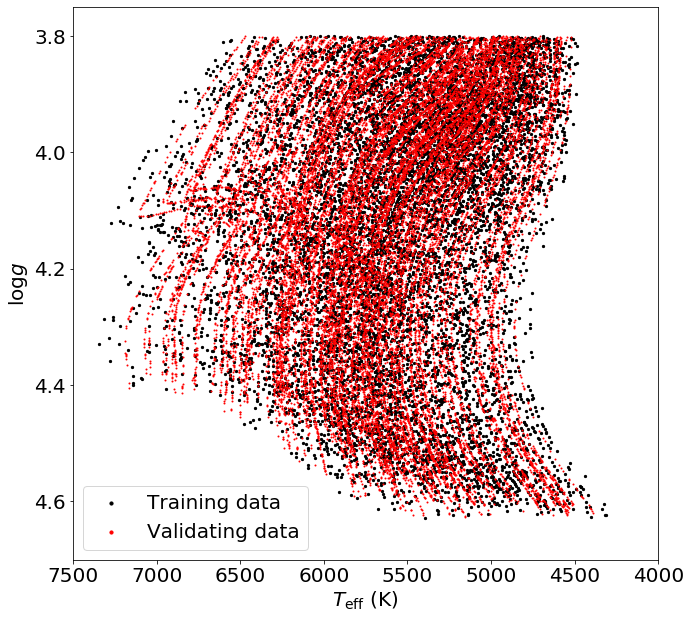

In [8]:
textsize = 20

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (11, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)

fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(gdf['effective_T'], gdf['log_g'], c = 'k',s = 5) 
#ax.scatter(dfvon['effective_T'], dfvon['log_g'], c = 'b',s = 1)
ax.scatter(dfv['effective_T'], dfv['log_g'], c = 'r',s = 1)

ax.scatter(0, 0, c = 'k',s = 10, label = 'Training data')
#ax.scatter(0, 0, c = 'b',s = 10, label = 'Testing data')
ax.scatter(0,0, c = 'r',s = 10, label = 'Validating data')

ax.set_xlabel(r'$T_{\rm eff}$ (K)')
ax.set_ylabel(r'$\log g$')
ax.set_xlim([7500,4000])
ax.set_ylim([4.7,3.75])
ax.legend(fontsize = 20)

#cp = ax[1].scatter(gdf['initial_mass'], gdf['frac_age'], c = 'k',s = 10, label = 'Training data') #,cmap = 'hot')
#ax[1].scatter(dfv['initial_mass'], dfv['frac_age'], c = 'r',s = 10, label = 'Testing data') #,cmap = 'hot')
#ax[1].set_xlabel(r'$M/M_{\odot}$')
#ax[1].set_ylabel(r"$t'$")
fig.tight_layout()
fig.savefig(gmk._savepath + 'M0_data_on_HR.pdf')
#ax1.set_title('MESA grid models')

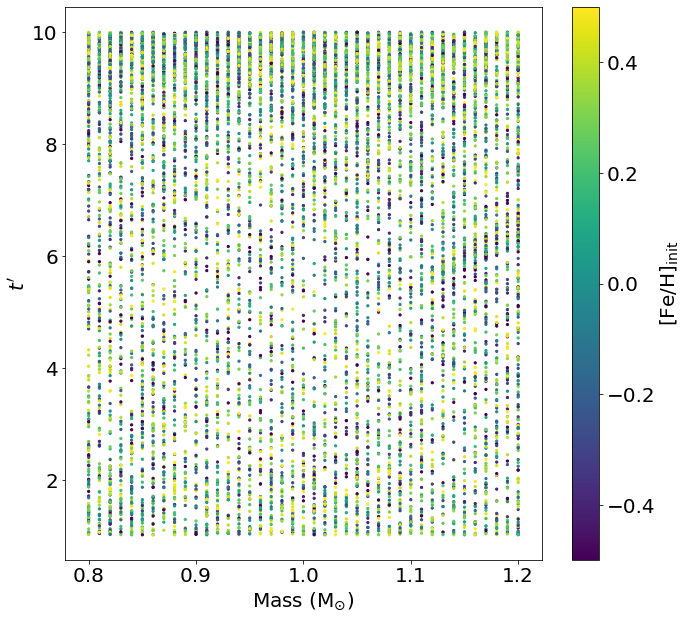

In [10]:
fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(gdf['initial_mass'], gdf['frac_age'], c = gdf['initial_feh'],s = 5) 
ax.set_xlabel(r'Mass (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")


#cp = ax[1].scatter(gdf['initial_mass'], gdf['frac_age'], c = 'k',s = 10, label = 'Training data') #,cmap = 'hot')
#ax[1].scatter(dfv['initial_mass'], dfv['frac_age'], c = 'r',s = 10, label = 'Testing data') #,cmap = 'hot')
#ax[1].set_xlabel(r'$M/M_{\odot}$')
#ax[1].set_ylabel(r"$t'$")
cc = plt.colorbar(cp)
cc.set_label(r'[Fe/H]$_{\rm init}$')
fig.tight_layout()
fig.savefig(gmk._savepath + 'M0_data.pdf')
#ax1.set_title('MESA grid models')

In [11]:
# Train and validate
def train_and_validate(gdf, dfv, kname, label):
    print('training ' + label)
    gpm = gmk.gp_a_dataframe(df = gdf, xcolumns = xcolumns, ycolumns = ycolumns, kname = kname)
    #
    np.save(gmk._savepath + label + '_gpm_.npy', gpm.param_array)
    gdf.to_csv(gmk._savepath + label + '_gpm_.csv')
    #    
    print('validating ...')
    gpp = dfv.copy()
    offsets = dfv.copy()
    gpp = gmk.sample_with_df(n = 1, df = dfv, gpm = gpm, 
                             xcolumns = xcolumns, xshift = xshifts, 
                             randomshift = False, ycolumns = ycolumns)
    gpp.to_csv(gmk._savepath + label + '_gpp_.csv')
    offsets[ycolumns] = dfv[ycolumns] - gpp[ycolumns]
    validations = np.percentile(np.abs(offsets[ycolumns]), [50, 95, 99.8, 100])
    print('Model---50%----95%---99.8%---100%')
    print(label, validations)
    #
    fig, ax = plt.subplots(1,1, figsize = (10,9))
    cp = ax.scatter(dfv['initial_mass'], dfv['frac_age'], c = offsets[ycolumns[0]],s = 10) 
    ax.set_xlabel(r'Mass (M$_{\odot}$)')
    ax.set_ylabel(r"$t'$")
    #ax.set_xlim([7000,4750])
    #ax.set_ylim([4.7,3.7])
    cc = plt.colorbar(cp)
    cc.set_label(ycolumns[0])
    ax.set_title(label)
    #ax.legend(fontsize = 20)
    fig.tight_layout()
    fig.savefig(gmk._savepath + label +'validation.pdf')
    
    return gpm, gpp, offsets, validations

In [12]:
### Train model0
#kname = 'MLP'
#label = 'M0_all' + kname 
#gpm0, gpp0, offsets0, validations0 = train_and_validate(gdf, dfv, kname, label)

 /opt/anaconda3/lib/python3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!



Name : GP regression
Objective : 34375.58232192251
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  mlp.variance             |  206324.86708229914  |      +ve      |        
  mlp.weight_variance      |                (3,)  |      +ve      |        
  mlp.bias_variance        |  1391.0415006363307  |      +ve      |        
  Gaussian_noise.variance  |  10.796475898292549  |      +ve      |        
Model---50%----95%---99.8%---100%
[  1.62538355   9.73214891  49.46863054 124.2308948 ]


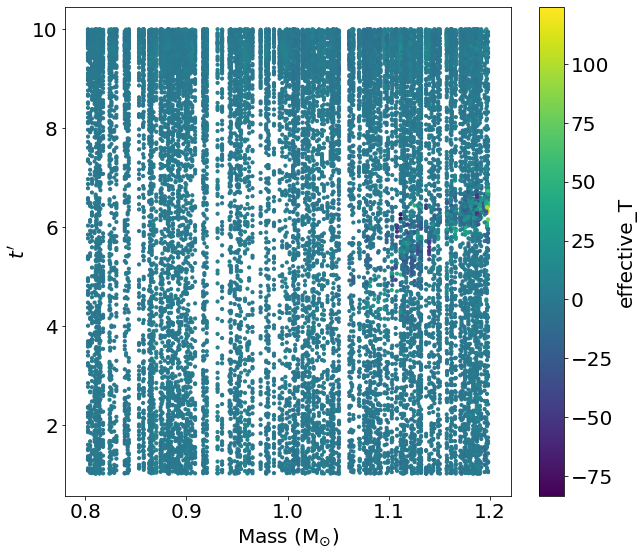

In [13]:
### load model0
kname = 'MLP'
gdf = gdf
npy = savedr + 'M0_allMLP_gpm_.npy'
gpm0 = gmk.load_a_gpm(df = gdf, npy = npy, xcolumns = xcolumns, ycolumns = ycolumns, kname = kname)

offsets0 = dfv.copy()
gpp0 = pd.read_csv(savedr + 'M0_allMLP_gpp_.csv')
offsets0[ycolumns] = dfv[ycolumns] - gpp0[ycolumns]
offsets0.to_csv(savedr + 'M0_allMLP_offsets_.csv')
validations0 = np.percentile(np.abs(offsets0[ycolumns]), [50, 95, 99.8, 100])
print('Model---50%----95%---99.8%---100%')
print(validations0)

fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(dfv['initial_mass'], dfv['frac_age'], c = offsets0[ycolumns[0]],s = 10) 
ax.set_xlabel(r'Mass (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")
#ax.set_xlim([7000,4750])
#ax.set_ylim([4.7,3.7])
cc = plt.colorbar(cp)
cc.set_label(ycolumns[0])
#ax.set_title(label)

 # work on residuls (1-order)

In [14]:
def make_training_data_for_residual(sdf, gpms, label):
    
    gpp = sdf.copy()
    gdfr = sdf.copy()
    
    for gpm in gpms:
        gpp = gmk.sample_with_df(n = 1, df = sdf, gpm = gpm, 
                                 xcolumns = xcolumns, xshift = xshifts, 
                                 randomshift = False, ycolumns = ycolumns)
        gdfr[ycolumns] = gdfr[ycolumns] - gpp[ycolumns]
    #    
    gdfr['weights'] = np.abs(gdfr[ycolumns])
    gdfr = gdfr.sample(n = ntraining, weights = 'weights', random_state = 99)
    gdfr.to_csv(gmk._savepath + label + '_gdfr_.csv')
    
    fig, ax = plt.subplots(1,1, figsize = (10,9))
    cp = ax.scatter(gdfr['initial_mass'], gdfr['frac_age'], c = gdfr[ycolumns[0]],s = 10) 
    ax.set_xlabel(r'Mass')
    ax.set_ylabel(r"$t'$")
    cc = plt.colorbar(cp)
    cc.set_label(ycolumns[0])
    ax.set_title(label)
    fig.tight_layout()
    fig.savefig(gmk._savepath + label +'.png')    
    return gdfr

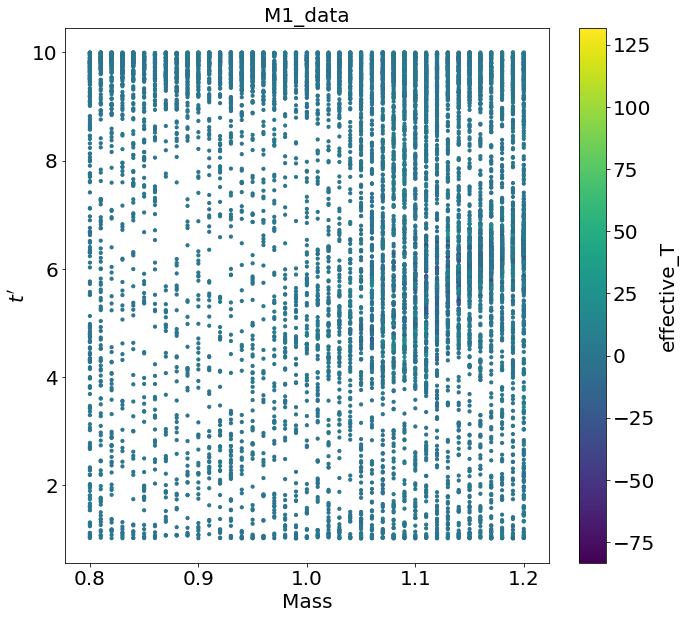

In [15]:
#sdf = df.sample(n = nresidual, weights = 'hrgradient', random_state = 139)
#sdf.index = range(len(sdf))
#gpms = [gpm0]
#label = 'M1_data'
#gdf1 = make_training_data_for_residual(sdf, gpms, label)

training M1_MLP
--- 1488.9211571216583 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_MLP [  1.63607998   9.67730054  49.52272333 124.12606745]
training M1_EXP
--- 858.8861141204834 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_EXP [  1.62538355   9.73214891  49.46863054 124.2308948 ]
training M1_RBF
--- 2978.921488046646 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_RBF [  1.62538355   9.73214891  49.46863054 124.2308948 ]
training M1_RQ
--- 1048.4486730098724 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_RQ [  1.62538355   9.73214891  49.46863054 124.2308948 ]
training M1_Mat32
--- 2233.4836778640747 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_Mat32 [ 1.61018653  9.52473806 45.12251209 95.57172694]


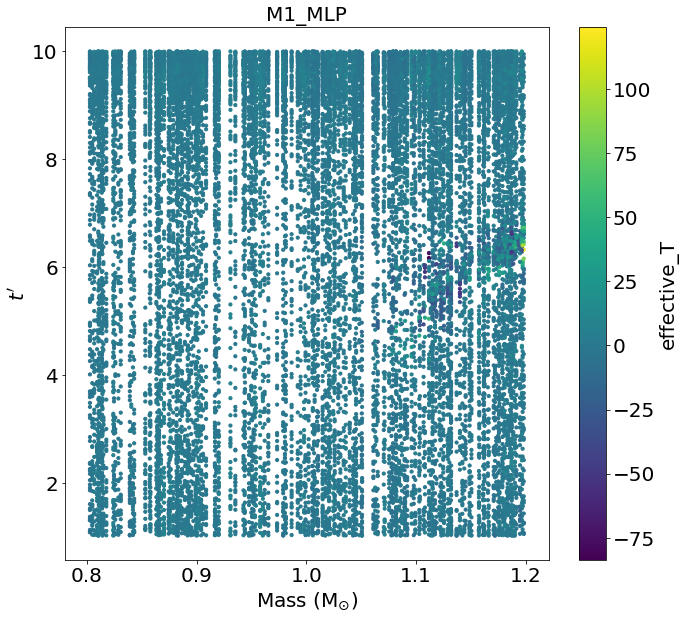

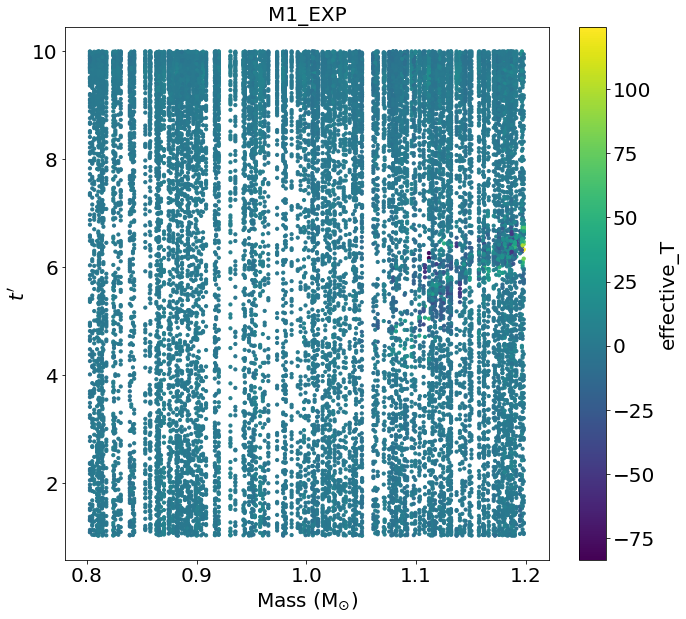

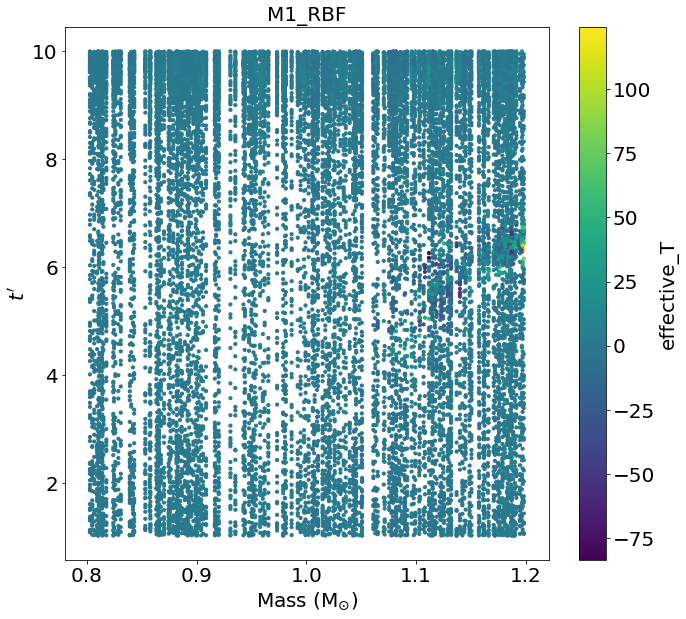

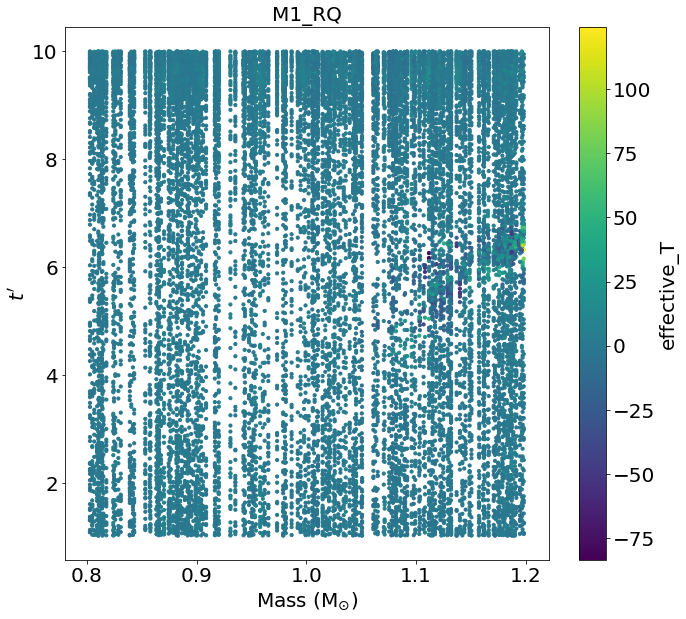

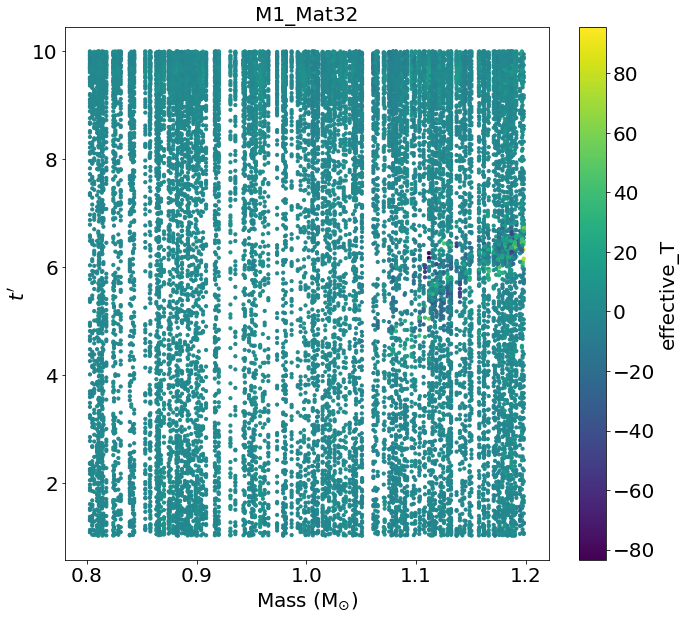

In [16]:
#knames = ['MLP', 'EXP', 'RBF', 'RQ', 'Mat32']
#for kname in knames:
#    label = 'M1_' + kname 
#    gpm1, gpp1, offsets1, validations1 = train_and_validate(gdf1, offsets0, kname, label)

In [22]:
# the Mat32 kernel wins, so gmp1 kernel is 'mat32'
#kname = 'Mat32'
#label = 'M1_winner_' + kname
#gpm1, gpp1, offsets1, validations1 = train_and_validate(gdf1, offsets0, kname, label)


Name : GP regression
Objective : 34504.83716848641
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  Mat32.variance           |  25.665039475376883  |      +ve      |        
  Mat32.lengthscale        |                (3,)  |      +ve      |        
  Gaussian_noise.variance  |  12.735318972363382  |      +ve      |        
Model---50%----95%---99.8%---100%
[ 1.61018653  9.52473806 45.12251209 95.57172694]


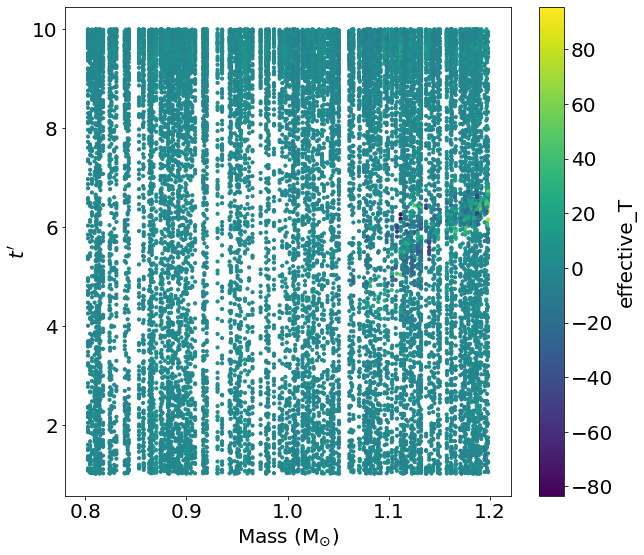

In [15]:
kname = 'Mat32'
gdf1 = pd.read_csv(savedr + 'M1_winner_Mat32_gpm_.csv')
npy = savedr + 'M1_winner_Mat32_gpm_.npy'
gpm1 = gmk.load_a_gpm(df = gdf1, npy = npy, xcolumns = xcolumns, ycolumns = ycolumns, kname = kname)

offsets1 = dfv.copy()
gpp1 = pd.read_csv(savedr + 'M1_winner_Mat32_gpp_.csv')
offsets1[ycolumns] = offsets0[ycolumns] - gpp1[ycolumns]
offsets1.to_csv(savedr + 'M1_winner_Mat32_offsets_.csv')
validations1 = np.percentile(np.abs(offsets1[ycolumns]), [50, 95, 99.8, 100])
print('Model---50%----95%---99.8%---100%')
print(validations1)

fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(dfv['initial_mass'], dfv['frac_age'], c = offsets1[ycolumns[0]],s = 10) 
ax.set_xlabel(r'Mass (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")
#ax.set_xlim([7000,4750])
#ax.set_ylim([4.7,3.7])
cc = plt.colorbar(cp)
cc.set_label(ycolumns[0])
#ax.set_title(label)

# 2nd-order residuals

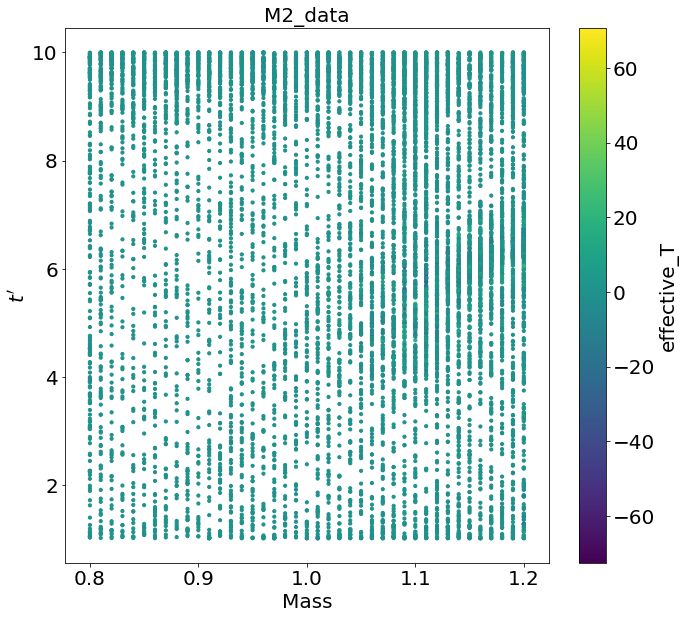

In [16]:
#sdf = df.sample(n = nresidual, weights = 'hrgradient', random_state = 887)
#sdf.index = range(len(sdf))
#gpms = [gpm0,gpm1]
#label = 'M2_data'
#gdf2 = make_training_data_for_residual(sdf, gpms, label)

gdf2 = pd.read_csv(savedr + 'M2_data_gdfr_.csv')

In [ ]:
knames = ['MLP', 'EXP', 'RBF', 'RQ']
for kname in knames:
    label = 'M2_' + kname 
    gpm2, gpp2, offsets2, validations2 = train_and_validate(gdf2, offsets1, kname, label)

training M2_MLP
--- 1759.1470911502838 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_MLP [ 1.61302598  9.54930281 45.18132255 95.630592  ]
training M2_EXP
--- 2389.36327624321 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_EXP [ 1.54866175  8.88889469 39.04694958 68.53606371]
training M2_RBF
--- 3820.6765739917755 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_RBF [ 1.60256062  9.46725497 44.08974101 94.76423587]
training M2_RQ
--- 6196.0529961586 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_RQ [ 1.62128345  9.5497003  44.52665815 95.38389984]
training M2_Mat32


training M2_Mat32
--- 3388.0219161510468 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_Mat32 [ 1.60651693  9.52128996 44.27326553 95.57165368]


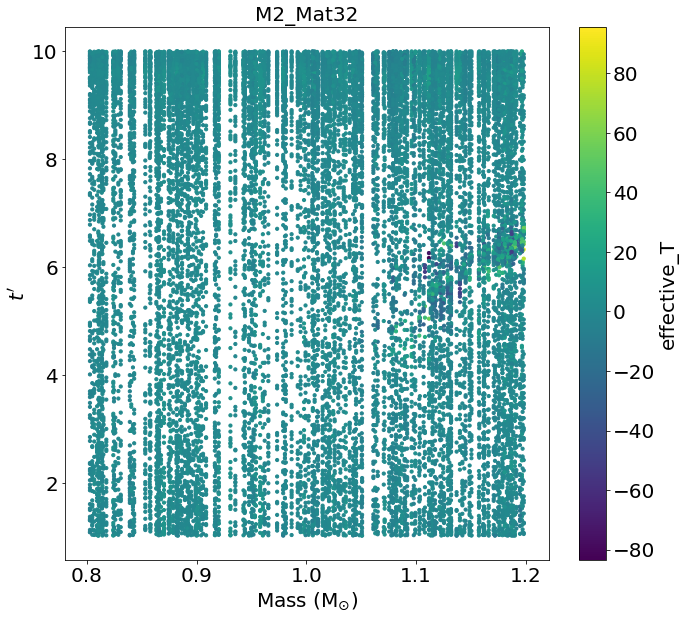

In [17]:
knames = ['Mat32']
for kname in knames:
    label = 'M2_' + kname 
    gpm2, gpp2, offsets2, validations2 = train_and_validate(gdf2, offsets1, kname, label)

training M2_winnerMat32
--- 3329.5798001289368 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_winnerMat32 [ 1.60651693  9.52128996 44.27326553 95.57165368]


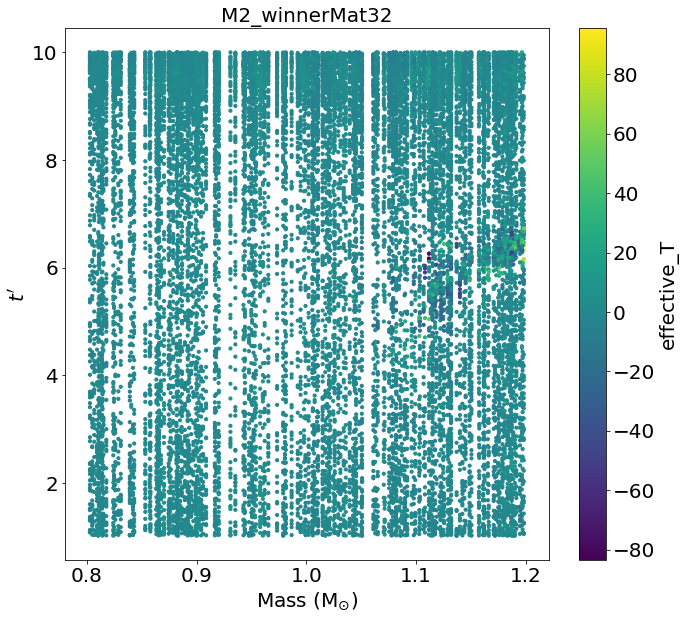

In [18]:
# EXP wins
#kname = 'EXP'
#label = 'M2_winner' + kname 
#gpm2, gpp2, offsets2, validations2 = train_and_validate(gdf2, offsets1, kname, label)


Name : GP regression
Objective : 27075.834632783215
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  Exponential.variance     |       21.15038148252336  |      +ve      |        
  Exponential.lengthscale  |                    (3,)  |      +ve      |        
  Gaussian_noise.variance  |  2.2858401537688078e-07  |      +ve      |        
Model---50%----95%---99.8%---100%
[ 1.54866175  8.88889469 39.04694958 68.53606371]


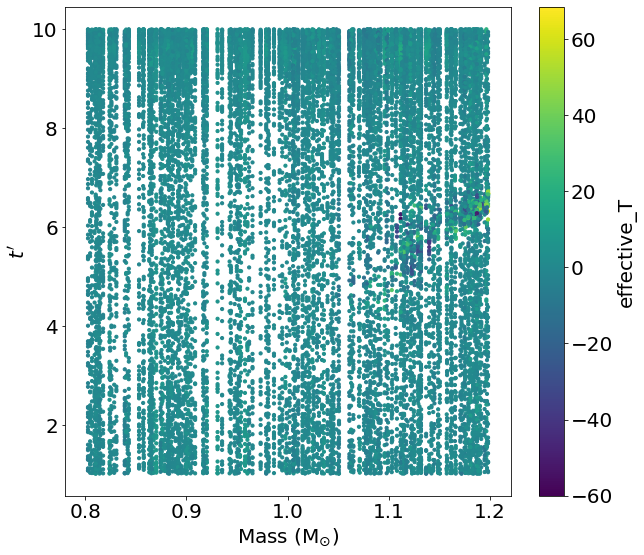

In [18]:
kname = 'EXP'
gdf2 = pd.read_csv(savedr + 'M2_winner_EXP_gpm_.csv')
npy = savedr + 'M2_winner_EXP_gpm_.npy'
gpm2 = gmk.load_a_gpm(df = gdf2, npy = npy, xcolumns = xcolumns, ycolumns = ycolumns, kname = kname)

offsets2 = dfv.copy()
gpp2 = pd.read_csv(savedr + 'M2_winner_EXP_gpp_.csv')
offsets2[ycolumns] = offsets1[ycolumns] - gpp2[ycolumns]
offsets2.to_csv(savedr + 'M2_winner_EXP_offsets_.csv')
validations2 = np.percentile(np.abs(offsets2[ycolumns]), [50, 95, 99.8, 100])
print('Model---50%----95%---99.8%---100%')
print(validations2)

fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(dfv['initial_mass'], dfv['frac_age'], c = offsets2[ycolumns[0]],s = 10) 
ax.set_xlabel(r'Mass (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")
#ax.set_xlim([7000,4750])
#ax.set_ylim([4.7,3.7])
cc = plt.colorbar(cp)
cc.set_label(ycolumns[0])
#ax.set_title(label)

# 3rd order residual.

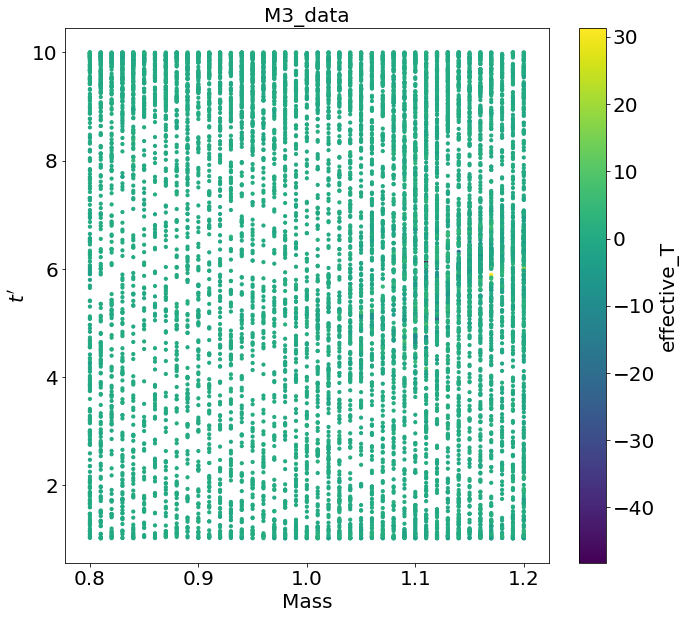

In [19]:
sdf = df.sample(n = nresidual, weights = 'hrgradient', random_state = 608)
sdf.index = range(len(sdf))
gpms = [gpm0,gpm1,gpm2]
label = 'M3_data'
gdf3 = make_training_data_for_residual(sdf, gpms, label)

In [ ]:
knames = ['MLP', 'EXP', 'RBF', 'RQ', 'Mat32']
for kname in knames:
    label = 'M3_' + kname
    gpm3 = gpp3 = offsets3 = validations3 = None
    gpm3, gpp3, offsets3, validations3 = train_and_validate(gdf3, offsets2, kname, label)

training M3_MLP
--- 3627.2219710350037 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M3_MLP [ 1.54951213  8.91215261 40.0408125  68.79823734]
training M3_EXP
--- 2876.4264209270477 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M3_EXP [ 1.53962942  8.88979526 39.19856439 68.87210173]
training M3_RBF
--- 1214.9839899539948 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M3_RBF [ 1.55112935  8.89029012 39.11138394 68.60200132]
training M3_RQ
--- 2397.5801248550415 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M3_RQ [ 1.55102439  8.89186715 39.11335441 68.60401307]
training M3_Mat32


 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


--- 1552.7757790088654 seconds ---
validating ...


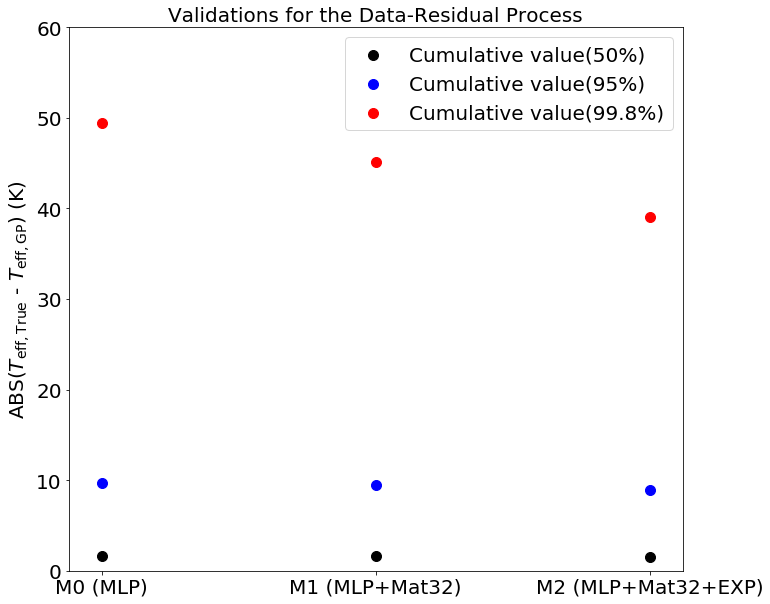

In [22]:
px = np.array([0,1,2])
pv_off = np.array([validations0, validations1, validations2])
pv_off

plt.scatter(px, pv_off[:,0],s = 100,facecolors='k', edgecolors='k',label = 'Cumulative value(50%)')
plt.scatter(px, pv_off[:,1],s = 100,facecolors='b', edgecolors='b',label = 'Cumulative value(95%)')
plt.scatter(px, pv_off[:,2],s = 100,facecolors='r', edgecolors='r',label = 'Cumulative value(99.8%)')
plt.scatter(px, pv_off[:,3],s = 100,facecolors='g', edgecolors='g',label = 'Maximum value')


plt.yscale('linear')
plt.xticks([0,1,2], ('M0 (MLP)', 'M1 (MLP+Mat32)', 'M2 (MLP+Mat32+EXP)'))
plt.ylim([-0.00,150])
plt.title('Validations for the Data-Residual Process')
plt.ylabel(r'ABS($T_{\rm eff, True}$ - $T_{\rm eff, GP}$) (K)')
plt.legend()